## Реализация портфельной теории Марковица для акций МосБиржи

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

from datetime import datetime
import datetime 

from tqdm import tqdm

from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt.efficient_frontier import EfficientFrontier, EfficientCVaR, EfficientSemivariance, EfficientCDaR
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt import get_latest_prices
from pypfopt import DiscreteAllocation
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter

import requests
import apimoex

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 12})

### Файл с тикетами акций, доступных для неквалифицированного инвестора

In [2]:
df_of_bonds = pd.read_csv('D:/Desktop/Работа/Markowitz_theory/bond_names_unskilled.txt')
list_of_bonds = df_of_bonds.bond_name

## Исторические данные для анализа собираются за один год

In [3]:
today_day = str(datetime.datetime.today().year) + '-' + str(datetime.datetime.today().month) + '-' + str(datetime.datetime.today().day)
today_day

'2023-11-7'

In [4]:
start_date_of_analysis =  datetime.datetime.now() - datetime.timedelta(days=1*365)
start_date_of_analysis = str(start_date_of_analysis.year) + '-' + str(start_date_of_analysis.month) + '-' + str(start_date_of_analysis.day)
start_date_of_analysis

'2022-11-7'

In [5]:
with requests.Session() as session:
    data = apimoex.get_board_history(session, str(list_of_bonds[0]), start_date_of_analysis, today_day, ('TRADEDATE', 'CLOSE'))
    df_stocks = pd.DataFrame(data).rename(columns={'TRADEDATE':'date', 'CLOSE':'price'})
    first_date = df_stocks.iloc[0].date

In [6]:
df_stocks = df_stocks.rename(columns={'price':str(list_of_bonds[0][:4])}).set_index('date')

### Тикеты, которые не будут собираться

Есть пропуски данных, нет данных по привелигированным акциям

In [7]:
list_of_prohibited_bonds = ['FEES', 'POLY', 'ABIO','TGKN', 'SVAV', 
                            'WUSH', 'ASTR', 'SOFL', 'ELFV', 'TRNFP', 
                            'TATNP', 'RTKMP', 'SBERP', 'SNGSP', 'MTLRP'
                           ]

### Сбор данных с сервера МосБиржи

In [8]:
for i in tqdm(range(1, len(list_of_bonds))):
    with requests.Session() as session:
        if str(list_of_bonds[i]) not in list_of_prohibited_bonds:
            data = apimoex.get_board_history(session, str(list_of_bonds[i]), start_date_of_analysis, today_day, ('TRADEDATE', 'CLOSE'))
            df = pd.DataFrame(data).rename(columns={'TRADEDATE':'date', 'CLOSE':'price'})
            if df.iloc[0].date == first_date:
                df = df.rename(columns={'price':str(list_of_bonds[i][:4])}).set_index('date')
                df_stocks = pd.concat([df_stocks, df], axis = 1)
            else:
                print(str(list_of_bonds[i][:4]))

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:22<00:00,  4.03it/s]


In [9]:
df_stocks

,AKRN,ALRS,APTK,AMEZ,AFLT,VTBR,BSPB,VSMO,GAZP,LSRG,...,HHRU,MDMG,OKEY,OZON,QIWI,AGRO,TCSG,GEMC,FIVE,YNDX
date,,,,,,,,,,,,,,,,,,,,,
2022-11-07,16598,66.30,12.228,27.000,26.24,0.016860,95.64,51240,169.85,496.0,...,1399,484.5,27.71,1397.5,362.5,812.0,2600.0,363.7,1619.5,2151.6
2022-11-08,16640,65.93,12.152,27.285,25.64,0.017250,94.38,49440,169.97,497.8,...,1379,478.7,28.34,1396.0,359.5,801.0,2598.5,354.0,1611.5,2127.6
2022-11-09,16608,65.40,12.030,26.370,24.96,0.016590,93.31,45760,167.10,488.0,...,1375,457.1,26.54,1408.0,353.0,791.2,2520.5,342.3,1559.5,2060.4
2022-11-10,16724,67.15,12.086,26.770,25.58,0.017290,96.01,49800,168.90,488.0,...,1393,463.9,27.18,1438.0,361.0,801.0,2672.0,347.1,1560.0,2111.6
2022-11-11,16776,68.61,12.080,26.770,25.62,0.017160,95.87,51100,169.86,480.8,...,1390,463.0,27.07,1447.0,364.0,810.6,2676.0,346.1,1567.5,2122.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,18930,69.98,15.410,91.170,39.35,0.025315,250.34,40200,167.88,664.6,...,3745,837.8,36.37,2598.0,628.5,1444.0,3416.0,816.6,2271.5,2612.0
2023-11-01,18900,70.50,15.502,91.180,39.25,0.025200,252.40,39100,170.08,670.4,...,3832,834.0,36.17,2616.0,633.0,1426.0,3445.5,815.4,2271.0,2639.8
2023-11-02,18902,70.87,15.438,90.730,39.25,0.025055,249.16,40220,168.18,675.0,...,3770,832.7,36.46,2630.5,622.0,1424.4,3424.5,825.0,2293.0,2625.6


Проверим наличие пропусков в собранных данных

In [10]:
df_stocks.isna().sum().value_counts()

0    76
Name: count, dtype: int64

In [11]:
df_stocks = df_stocks.dropna(how='any')

In [12]:
df_stocks.isna().sum().value_counts()

0    76
Name: count, dtype: int64

Считаем мат. ожидание, СКО с помощью библиотеки PyPortfolioOpt

In [13]:
#Годовая доходность
mu = expected_returns.mean_historical_return(df_stocks) 
historical_returns = expected_returns.returns_from_prices(df_stocks)
#Дисперсия портфеля
Sigma = risk_models.CovarianceShrinkage(df_stocks).ledoit_wolf()

Находим эффективную границу Марковица

In [14]:
#Максимальный коэффициент Шарпа
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
sharpe_pfolio=ef.max_sharpe()
sharpe_pwt=ef.clean_weights()

In [15]:
list_of_w = list(sharpe_pwt)

In [16]:
list(set(list_of_bonds) - set(list_of_w) - set(list_of_prohibited_bonds))

[]

Доходность, волатильность и коэф. Шарпа портфеля с максимальным коэффициентом Шарпа

In [17]:
ef.portfolio_performance(verbose=True)

Expected annual return: 189.0%
Annual volatility: 20.4%
Sharpe Ratio: 9.18


(1.8899947452748664, 0.20381106148637454, 9.175138638880412)

Доходность, волатильность и коэф. Шарпа портфеля с минимальной волатильностью

In [18]:
ef1 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) 
minvol=ef1.min_volatility()
minvol_pwt=ef1.clean_weights()

In [19]:
ef1.portfolio_performance(verbose=True)

Expected annual return: 25.3%
Annual volatility: 10.8%
Sharpe Ratio: 2.16


(0.25286283496061984, 0.10792055870004263, 2.1577245129711127)

Эффективная граница для МосБиржи

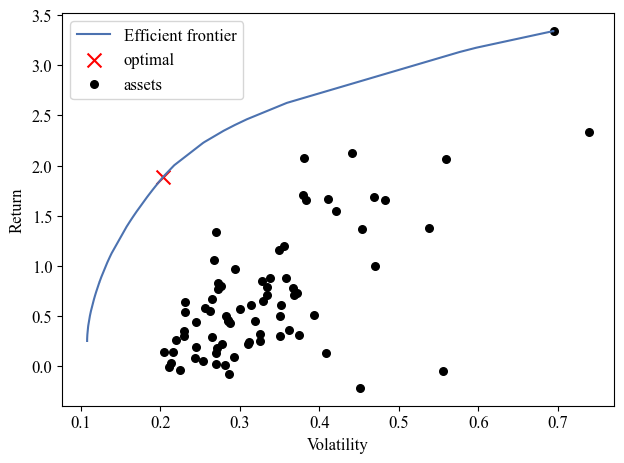

In [20]:
cl_obj = CLA(mu, Sigma)
ax = pplt.plot_efficient_frontier(cl_obj, showfig = True)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

Гистограмма тикетов активов для портфеля с максимальной коэф. Шарпа

<Axes: xlabel='Weight'>

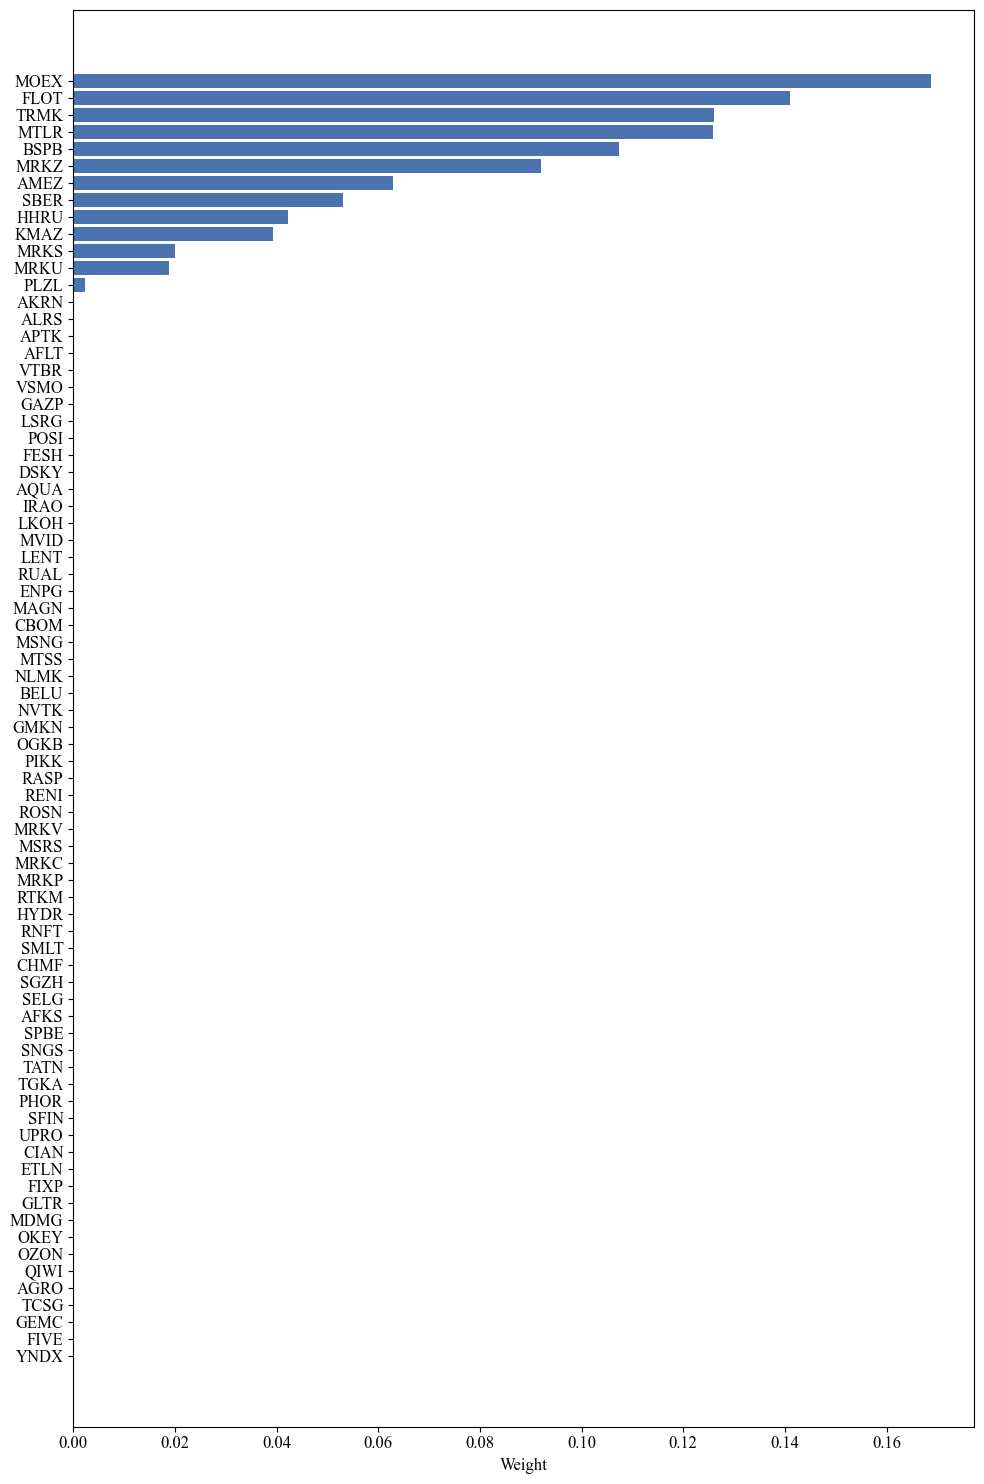

In [21]:
plt.figure(figsize=(10,15))
pplt.plot_weights(sharpe_pwt)

### Найдем практическую рекомендацию для инвестирования денег на Мосбиржи

Количество денег для инвестиций

In [22]:
amount_of_money_to_invest = 100_000

In [23]:
latest_prices = get_latest_prices(df_stocks)
allocation_minv, rem_minv = DiscreteAllocation(minvol_pwt, latest_prices, total_portfolio_value=amount_of_money_to_invest).greedy_portfolio() 
print(allocation_minv)
print("Осталось денежных средств после построения портфеля с минимальной волатильностью - {:.2f} рублей".format(rem_minv))
print()

{'AKRN': 1, 'PHOR': 1, 'CBOM': 1110, 'GAZP': 42, 'SFIN': 11, 'MTSS': 22, 'DSKY': 76, 'LENT': 7, 'APTK': 306, 'LKOH': 1, 'RENI': 30, 'ROSN': 5, 'MSRS': 1776, 'OGKB': 3974, 'TATN': 3, 'POSI': 1, 'BSPB': 7, 'RUAL': 35, 'BELU': 1, 'MRKS': 680, 'MRKP': 1339}
Осталось денежных средств после построения портфеля с минимальной волатильностью - 27.05 рублей



In [24]:
latest_prices1 = get_latest_prices(df_stocks)
allocation_shp, rem_shp = DiscreteAllocation(sharpe_pwt, latest_prices1, total_portfolio_value=amount_of_money_to_invest).greedy_portfolio() 
print(allocation_shp)
print("Осталось денежных средств после построения портфеля с максимальным коэффициентом Шарпа {:.2f} рублей".format(rem_shp))

{'MOEX': 82, 'FLOT': 117, 'TRMK': 58, 'MTLR': 45, 'BSPB': 44, 'MRKZ': 87471, 'AMEZ': 70, 'SBER': 20, 'HHRU': 1, 'KMAZ': 17, 'MRKS': 2663, 'MRKU': 4297}
Осталось денежных средств после построения портфеля с максимальным коэффициентом Шарпа 67.11 рублей


In [25]:
from pypfopt import plotting

Эффективная граница со случайными портфелями

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


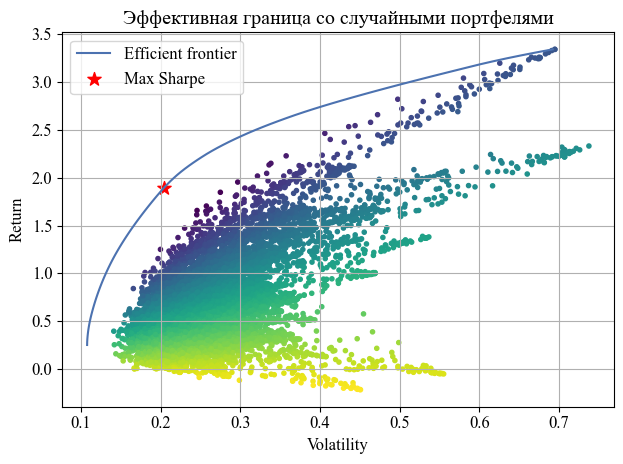

In [26]:
fig, ax = plt.subplots()
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)


ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")


n_samples = 100_00
w = np.random.dirichlet(np.ones(ef.n_assets)*1e-2, n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")


ax.set_title("Эффективная граница со случайными портфелями")
ax.legend()
plt.tight_layout()
plt.grid()
plt.show()

Структура портфеля для максимального коэф. Шарпа

In [27]:
allocation_shp

{'MOEX': 82,
 'FLOT': 117,
 'TRMK': 58,
 'MTLR': 45,
 'BSPB': 44,
 'MRKZ': 87471,
 'AMEZ': 70,
 'SBER': 20,
 'HHRU': 1,
 'KMAZ': 17,
 'MRKS': 2663,
 'MRKU': 4297}

Структура портфеля для минимальной волатильности

In [28]:
allocation_minv

{'AKRN': 1,
 'PHOR': 1,
 'CBOM': 1110,
 'GAZP': 42,
 'SFIN': 11,
 'MTSS': 22,
 'DSKY': 76,
 'LENT': 7,
 'APTK': 306,
 'LKOH': 1,
 'RENI': 30,
 'ROSN': 5,
 'MSRS': 1776,
 'OGKB': 3974,
 'TATN': 3,
 'POSI': 1,
 'BSPB': 7,
 'RUAL': 35,
 'BELU': 1,
 'MRKS': 680,
 'MRKP': 1339}

In [29]:
list_of_bonds_all = list(df_stocks.columns)
list_of_bonds_for_sharp = list(allocation_shp)
list_of_bonds_for_min = list(allocation_minv)

In [30]:
list_sigma_sharp = []
list_sigma_min = []
list_sigma_all = []
for i in range(len(list_of_bonds_for_sharp)):
    list_sigma_sharp.append((Sigma.loc[list_of_bonds_for_sharp[i]][list_of_bonds_for_sharp[i]])**(1/2))
    
for i in range(len(list_of_bonds_for_min)):
    list_sigma_min.append((Sigma.loc[list_of_bonds_for_min[i]][list_of_bonds_for_min[i]])**(1/2))
    
for i in range(len(list_of_bonds_all)):
    list_sigma_all.append((Sigma.loc[list_of_bonds_all[i]][list_of_bonds_all[i]])**(1/2))

In [31]:
df_of_sharp = pd.DataFrame({
    'bonds':list_of_bonds_for_sharp,
    'mu':np.array(mu[list(allocation_shp)]),
    'sigma':np.array(list_sigma_sharp)
})

df_of_min = pd.DataFrame({
    'bonds':list_of_bonds_for_min,
    'mu':np.array(mu[list(allocation_minv)]),
    'sigma':np.array(list_sigma_min)
})

df_of_all = pd.DataFrame({
    'bonds':list_of_bonds_all,
    'mu':np.array(mu),
    'sigma':np.array(list_sigma_all)
})

График доходности-волатильности активов с активами для максимального коэф.  Шарпа

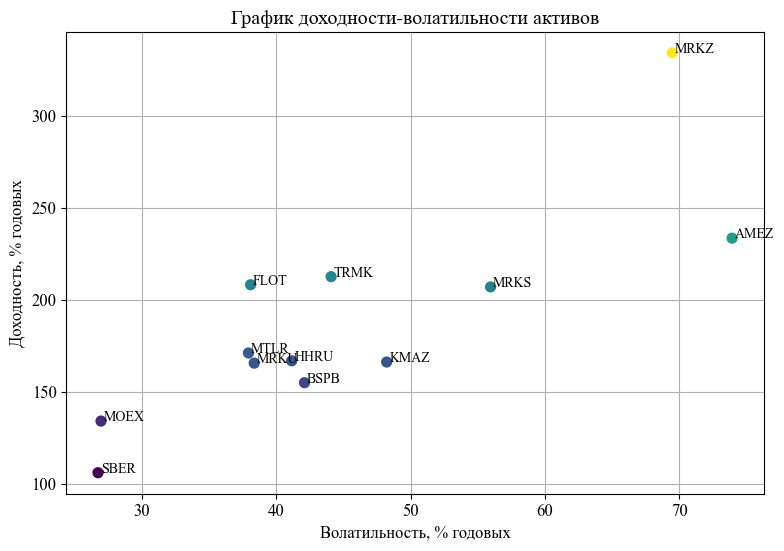

In [32]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(df_of_sharp.sigma*100, df_of_sharp.mu*100, c=df_of_sharp.mu*100, s=50)
ax.set_ylabel('Доходность, % годовых')
ax.set_xlabel('Волатильность, % годовых')
ax.set_title('График доходности-волатильности активов')
for idx, row in df_of_sharp.iterrows():
    ax.annotate(row['bonds'], (row['sigma']*100+0.2, row['mu']*100+0.2), fontsize=10) #row['bond_name']

plt.grid()
plt.show()

График доходности-волатильности активов с активами для минимальной волатильности

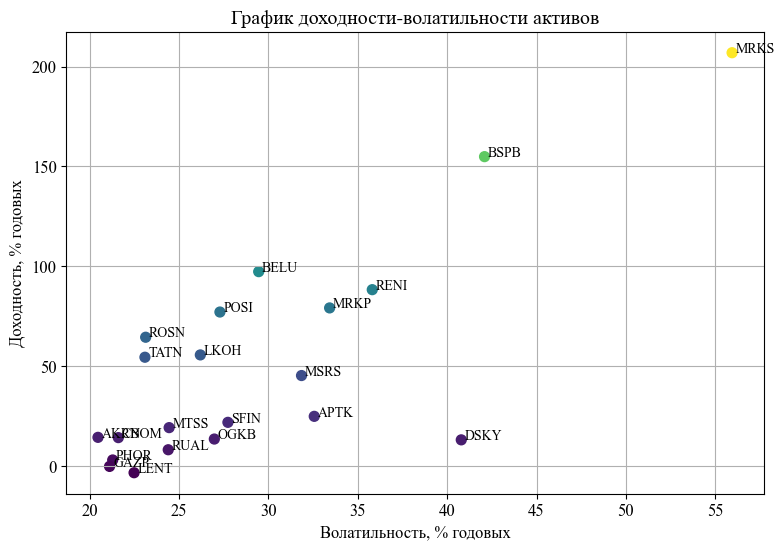

In [33]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(df_of_min.sigma*100, df_of_min.mu*100, c=df_of_min.mu*100, s=50)
ax.set_ylabel('Доходность, % годовых')
ax.set_xlabel('Волатильность, % годовых')
ax.set_title('График доходности-волатильности активов')
for idx, row in df_of_min.iterrows():
    ax.annotate(row['bonds'], (row['sigma']*100+0.2, row['mu']*100+0.2), fontsize=10) #row['bond_name']

plt.grid()
plt.show()

Общий график активов

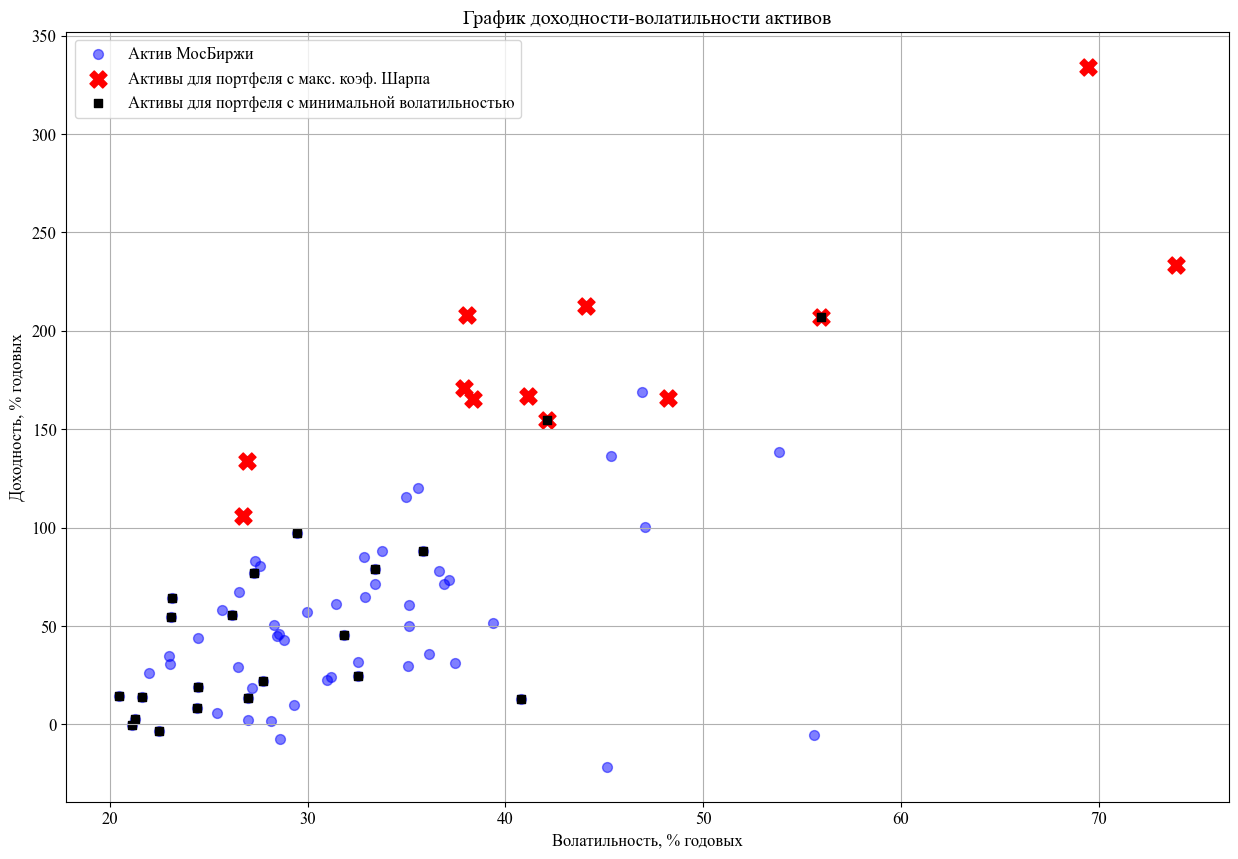

In [34]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df_of_all.sigma*100, df_of_all.mu*100, s=50, color='blue', label='Актив МосБиржи', alpha=0.5)
ax.scatter(df_of_sharp.sigma*100, df_of_sharp.mu*100, c='red', s=150, marker='X', label='Активы для портфеля с макс. коэф. Шарпа')
ax.scatter(df_of_min.sigma*100, df_of_min.mu*100, s=35, marker='s', color='black', label='Активы для портфеля с минимальной волатильностью')
ax.set_ylabel('Доходность, % годовых')
ax.set_xlabel('Волатильность, % годовых')
ax.set_title('График доходности-волатильности активов')
# for idx, row in df_of_all.iterrows():
#     ax.annotate(row['bonds'], (row['sigma']*100+0.2, row['mu']*100+0.2), fontsize=10) #row['bond_name']

plt.grid()
plt.legend()
plt.show()